## Homework 2

- Constantin Nicolai, 4079820
- Nils Kochendörfer, 3654093


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
from tensorflow import keras

2023-11-20 15:37:51.713805: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 15:37:51.759609: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 15:37:52.028146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 15:37:52.028272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 15:37:52.074917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(test_images.shape)

model=tf.keras.models.load_model('my_org_model_top4_quant.h5')

a = model.get_weights()

#which means that it will return the input tensors of each layer in the original model. 
#This allows you to access the intermediate activations of all layers in the model for a given input.
extractor_in = keras.Model(inputs=model.inputs,
                        outputs=[layer.input for layer in model.layers])

# The 'test_images' data is passed through the extractor_in model, 
#and the output of this operation is stored in the features_in variable. 
#As a result, features_in will be a list of arrays, 
#with each array corresponding to the activations of the corresponding layer in the original model.
features_in = extractor_in(test_images)

(10000, 28, 28)


In [3]:
Multiplier_Exact=np.zeros([256,256])
for i in range(-128,128):
    for j in range(-128,128):
        Multiplier_Exact[i+128,j+128]=i*j

# Subtask 1.1

In [4]:
Multiplier_Approx0=Multiplier_Exact
Multiplier_Approx1=np.load("Approximate Mult1.npy")
Multiplier_Approx2=np.load("Approximate Mult2.npy")
Multiplier_Approx3=np.load("Approximate Mult3.npy")
Multiplier_Approx4=np.load("Approximate Mult4.npy")
Multiplier_Approx5=np.load("Approximate Mult5.npy")
Multiplier_Approx6=np.load("Approximate Mult6.npy")
Multiplier_Approx7=np.load("Approximate Mult7.npy")
Multiplier_Approx8=np.load("Approximate Mult8.npy")


In [5]:
def My_Mult_Var(a,b,t=0):
    if t==0:
        Multiplier_Approx=Multiplier_Approx0
    elif t==1:
        Multiplier_Approx=Multiplier_Approx1
    elif t==2:
        Multiplier_Approx=Multiplier_Approx2
    elif t==3:
        Multiplier_Approx=Multiplier_Approx3
    elif t==4:
        Multiplier_Approx=Multiplier_Approx4
    elif t==5:
        Multiplier_Approx=Multiplier_Approx5
    elif t==6:
        Multiplier_Approx=Multiplier_Approx6
    elif t==7:
        Multiplier_Approx=Multiplier_Approx7
    elif t==8:
        Multiplier_Approx=Multiplier_Approx8

    a=np.array(a)
    b=np.array(b)
    a_shape=np.shape(a)
    b=np.reshape(b,a_shape)
    res=np.zeros(a_shape)
    if len(a_shape)==1:
        for i in range(np.shape(a)[0]):
            res[i]=Multiplier_Approx[int(a[i])+128,int(b[i])+128]
    if len(a_shape)==2:
        for i in range(a_shape[0]):
            for j in range(a_shape[1]):
                res[i,j]=Multiplier_Approx[int(a[i,j])+128,int(b[i,j])+128]
    return res

In [6]:
def My_Matmul_LT_Var(a,b,t=0):
    a=np.array(a)
    b=np.array(b)
    a_shape=np.shape(a)
    b_shape=np.shape(b)
    res=np.zeros([a_shape[0],b_shape[1]])
    for i in range(a_shape[0]):
        for j in range(b_shape[1]):
            res[i,j]=np.sum(My_Mult_Var(a[i,:],b[:,j],t))
    return res

In [7]:
def My_Conv2d_LT_Var(a,b,t=0):
    a=np.array(a)
    b=np.array(b)
    a_shape=np.shape(a)
    b_shape=np.shape(b)
    res_shape1=np.abs(a_shape[0]-b_shape[0])+1
    res_shape2=np.abs(a_shape[1]-b_shape[1])+1
    res=np.zeros([res_shape1,res_shape2])
    for i in range(res_shape1):
        for j in range(res_shape2):
            res[i,j]=np.sum(My_Mult_Var(np.flip(b),a[i:i+b_shape[0],j:j+b_shape[1]],t))
    return res

In [8]:
def CNN_Visual(k,t):  # First Input Determines the Number of the Test Image, 
                            # and Second one Determines the Type of the Multiplier
    z1=np.floor(features_in[0][k]/2)     # Quantization
    z2=np.zeros([28,28,64])
    for i in range(64):
        for j in range(1):
            z2[:,:,i]=z2[:,:,i]+My_Conv2d_LT_Var(np.array(z1[:,:,j]),np.flip(a[0][:,:,j,i]),t)
        z2[:,:,i]=z2[:,:,i]+a[1][i]
    z3=np.maximum(0,z2)                 # ReLU
    z3=np.round((z3/np.max(z3))*127)    # Quantization
    z4=np.zeros([28,28,32])
    for i in range(32):
        for j in range(64):
             z4[:,:,i]=z4[:,:,i]+My_Conv2d_LT_Var(np.array(z3[:,:,j]),np.flip(a[2][:,:,j,i]),t)
        z4[:,:,i]=z4[:,:,i]+a[3][i]
    z5=np.maximum(0,z4)                # ReLU
    z5=np.round((z5/np.max(z5))*127)   # Quantization
    z6=np.zeros([28,28,16])
    for i in range(16):
        for j in range(32):
             z6[:,:,i]=z6[:,:,i]+My_Conv2d_LT_Var(np.array(z5[:,:,j]),np.flip(a[4][:,:,j,i]),t)
        z6[:,:,i]=z6[:,:,i]+a[5][i]
    z61=np.maximum(0,z6)              # ReLU
    z61=np.round((z61/np.max(z61))*127) # Quantization
    z7=np.zeros([26,26,8])
    for i in range(8):
        for j in range(16):
             z7[:,:,i]=z7[:,:,i]+My_Conv2d_LT_Var(np.array(z61[:,:,j]),np.flip(a[6][:,:,j,i]),t)
        z7[:,:,i]=z7[:,:,i]+a[7][i]
    z8=np.maximum(0,z7)                # ReLU
    z8=np.round((z8/np.max(z8))*127)   # Quantization
    z9=np.zeros([24,24,4])
    for i in range(4):
        for j in range(8):
             z9[:,:,i]=z9[:,:,i]+My_Conv2d_LT_Var(np.array(z8[:,:,j]),np.flip(a[8][:,:,j,i]),t)
        z9[:,:,i]=z9[:,:,i]+a[9][i]
    z10=np.maximum(0,z9)              # ReLU
    z10=np.round((z10/np.max(z10))*127)  # Quantization
    z13=np.reshape(z10,[1,-1])  #  Flatten layer
    z14=My_Matmul_LT_Var(z13,a[10],t)+a[11]  
    z15=np.maximum(0,z14) # ReLU
    z15=np.round((z15/np.max(z15))*127)  # Quantization
    z141=My_Matmul_LT_Var(z15,a[12],t)+a[13] # ReLU
    z151=np.maximum(0,z141)
    z151=np.round((z151/np.max(z151))*127) # Quantization
    z16=My_Matmul_LT_Var(z151,a[14],t)+a[15]
    z16=np.round((z16/np.max(z16))*127) # Quantization
    return np.argmax(z16), z3,z5,z61,z8,z10,z15,z151,z16

# Subtask 1.2

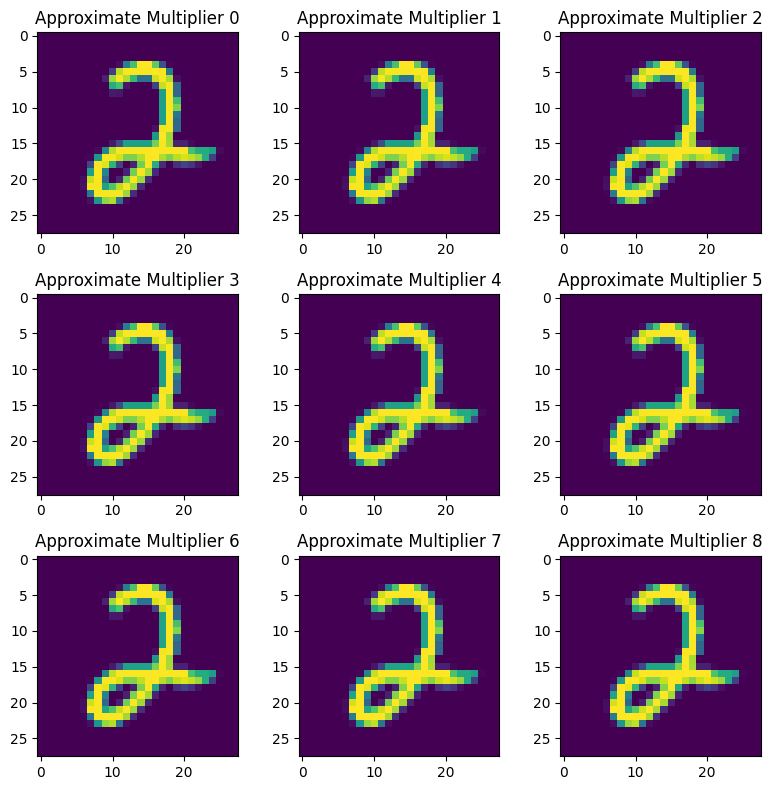

2

In [9]:
Vis_Mat=[]
for i in range(9):
    Vis_Mat.append(CNN_Visual(418,i))

images=[]
Layer_Number=1
for i in range(9):
    images.append(Vis_Mat[i][Layer_Number])

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop through your image data and plot each image on a subplot
for i, ax in enumerate(axes.ravel()):
    # Check if there are more images than subplots
    image_data=np.average(images,axis=-1)
    if i < len(image_data):
        ax.imshow(image_data[i])  # Plot the image
        ax.set_title(f'Approximate Multiplier {i}')  # Set a title for the subplot
    else:
        ax.axis('off')  # Turn off the empty subplots if there are fewer images

# Adjust spacing between subplots for better visualization
plt.tight_layout()

# Display the plot
plt.show()

#Result after CNN
Vis_Mat[0][0]

In [10]:
# Assuming you have already loaded the model and test data

# Compile the model if it's not already compiled
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy}')


313/313 [==============================] - 2s 4ms/step - loss: 56280855622598000640.0000 - accuracy: 0.9925
Test accuracy: 0.9925000071525574


313/313 [==============================] - 1s 4ms/step
10000


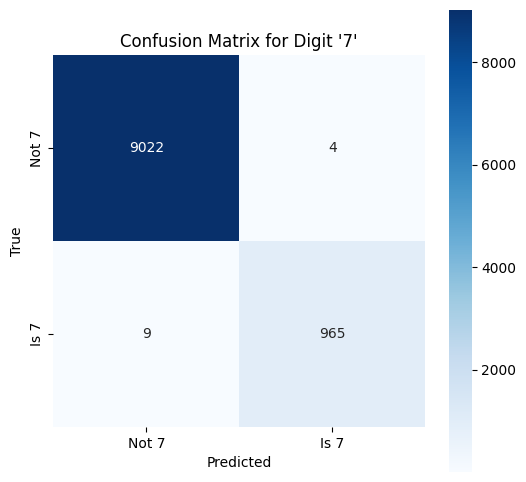

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


predictions = model.predict(test_images)
print(len(predictions))

# Find the indices of true "7" labels and predicted "7" labels
true_indices = (test_labels == 8)
predicted_indices = (np.argmax(predictions, axis=1) == 8)

# Create a confusion matrix for the digit "7"
confusion = confusion_matrix(true_indices, predicted_indices)

# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=["Not 7", "Is 7"],
            yticklabels=["Not 7", "Is 7"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix for Digit '7'")
plt.show()




# Intervention

I had to write up a little itervention right about here because I did not see how to fulfil the task and was not able to reach you tutors unfortunately. I did write in the moodle discussion some time ago and later I also wrote the same question as an email. \
I hope I simply lack some understanding for the code, but my trouble is that for the prediction accuracy evaluation with model.evaluate and the confusion matrix generated through model.predict we are using the given model. For the approximate images we plot from VisMat we have generated the input using our selfdefined CNN function. I however am not able to see how changing anything about our CNN function or its building block (e.g. the approximators) should affect the model objecct we use for the analysis. When I tried to let the CNN function run over a part of the test images it took forever and I it seemed morally unsound to waste so much energy on such an inefficient calculation. \
Therefore I do not understand how I am supposed to calculate the F1 score which I can find from my confusion matrix for the different approximators since I do not see how to make them affect my confusion matrix since this is created by using model.predict. 

# Subtask 1.3

For this one approximator I can calculate the F1 score.


### F1 Score Calculation Formula

The F1 score in terms of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) is calculated using the formula:

F1 Score = 2 * (TP) / (2 * TP + FP + FN)

where:
- TP (True Positives) represents the number of correctly predicted positive observations.
- FP (False Positives) represents the number of incorrectly predicted positive observations.
- FN (False Negatives) represents the number of incorrectly predicted negative observations.
- TN (True Negatives) represents the number of correctly predicted negative observations.


### Result

F1 Score = 0.993309315

# Subtask 1.4

Already done thanks for caring :)